# Import Libraries

In [28]:
import pandas as pd
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

## Loading Data

In [2]:
Transactions=pd.read_csv("Transactions.csv")
Products=pd.read_csv("Products.csv")
Transactions,Products

(    TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0          T00001      C0199      P067  2024-08-25 12:38:23         1   
 1          T00112      C0146      P067  2024-05-27 22:23:54         1   
 2          T00166      C0127      P067  2024-04-25 07:38:55         1   
 3          T00272      C0087      P067  2024-03-26 22:55:37         2   
 4          T00363      C0070      P067  2024-03-21 15:10:10         3   
 ..            ...        ...       ...                  ...       ...   
 995        T00496      C0118      P037  2024-10-24 08:30:27         1   
 996        T00759      C0059      P037  2024-06-04 02:15:24         3   
 997        T00922      C0018      P037  2024-04-05 13:05:32         4   
 998        T00959      C0115      P037  2024-09-29 10:16:02         2   
 999        T00992      C0024      P037  2024-04-21 10:52:24         1   
 
      TotalValue   Price  
 0        300.68  300.68  
 1        300.68  300.68  
 2        300.68  300.68  
 3

In [3]:
Transactions.info()
Products.info()
Transactions, Products

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB


(    TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0          T00001      C0199      P067  2024-08-25 12:38:23         1   
 1          T00112      C0146      P067  2024-05-27 22:23:54         1   
 2          T00166      C0127      P067  2024-04-25 07:38:55         1   
 3          T00272      C0087      P067  2024-03-26 22:55:37         2   
 4          T00363      C0070      P067  2024-03-21 15:10:10         3   
 ..            ...        ...       ...                  ...       ...   
 995        T00496      C0118      P037  2024-10-24 08:30:27         1   
 996        T00759      C0059      P037  2024-06-04 02:15:24         3   
 997        T00922      C0018      P037  2024-04-05 13:05:32         4   
 998        T00959      C0115      P037  2024-09-29 10:16:02         2   
 999        T00992      C0024      P037  2024-04-21 10:52:24         1   
 
      TotalValue   Price  
 0        300.68  300.68  
 1        300.68  300.68  
 2        300.68  300.68  
 3

# Cleaning and Preprocessing Data

In [4]:
Transactions['TransactionDate'] = pd.to_datetime(Transactions['TransactionDate'])

In [5]:
merged = pd.merge(Transactions, Products, on='ProductID', how='left')

In [7]:
top_products = merged.groupby('ProductName').agg({'Quantity': 'sum', 'TotalValue': 'sum'}).sort_values(
    'Quantity', ascending=False).reset_index()

In [8]:
sales_trends = merged.groupby(merged['TransactionDate'].dt.to_period('M')).agg({'TotalValue': 'sum'}).reset_index()


In [9]:
customers_df = pd.DataFrame({
    'CustomerID': [f'C{i:04d}' for i in range(1, 101)],
    'CustomerName': [f'Customer_{i}' for i in range(1, 101)],
    'Region': ['North America'] * 25 + ['Europe'] * 25 + ['Asia'] * 25 + ['South America'] * 25,
    'SignupDate': pd.date_range(start='2023-01-01', periods=100, freq='7D')
})

In [10]:
customer_features = merged.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'ProductID': lambda x: x.mode()[0]  # Most purchased product (mode)
}).reset_index()
customer_features.head()

,CustomerID,TotalValue,ProductID
0,C0001,3354.52,P022
1,C0002,1862.74,P004
2,C0003,2725.38,P002
3,C0004,5354.88,P008
4,C0005,2034.24,P012


In [11]:
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(customer_features[['TotalValue']])

In [12]:
similarity_matrix = cosine_similarity(normalized_features)

# Looklike Model

In [13]:
lookalike_results = {}
for i, customer_id in enumerate(customer_features['CustomerID'][:20]):
    similar_indices = similarity_matrix[i].argsort()[::-1][1:4]  # Get top 3 similar customers
    lookalike_results[customer_id] = [
        (customer_features['CustomerID'].iloc[idx], similarity_matrix[i][idx]) for idx in similar_indices
    ]
lookalike_results

{'C0001': [('C0075', 1.0), ('C0073', 1.0), ('C0072', 1.0)],
 'C0002': [('C0075', 1.0), ('C0073', 1.0), ('C0072', 1.0)],
 'C0003': [('C0075', 1.0), ('C0073', 1.0), ('C0072', 1.0)],
 'C0004': [('C0075', 1.0), ('C0073', 1.0), ('C0072', 1.0)],
 'C0005': [('C0075', 1.0), ('C0073', 1.0), ('C0072', 1.0)],
 'C0006': [('C0075', 1.0), ('C0073', 1.0), ('C0072', 1.0)],
 'C0007': [('C0075', 1.0), ('C0073', 1.0), ('C0072', 1.0)],
 'C0008': [('C0075', 1.0), ('C0073', 1.0), ('C0072', 1.0)],
 'C0009': [('C0075', 1.0), ('C0073', 1.0), ('C0072', 1.0)],
 'C0010': [('C0075', 1.0), ('C0073', 1.0), ('C0072', 1.0)],
 'C0011': [('C0075', 1.0), ('C0073', 1.0), ('C0072', 1.0)],
 'C0012': [('C0075', 1.0), ('C0073', 1.0), ('C0072', 1.0)],
 'C0013': [('C0075', 1.0), ('C0073', 1.0), ('C0072', 1.0)],
 'C0014': [('C0075', 1.0), ('C0073', 1.0), ('C0072', 1.0)],
 'C0015': [('C0075', 1.0), ('C0073', 1.0), ('C0072', 1.0)],
 'C0016': [('C0075', 1.0), ('C0073', 1.0), ('C0072', 1.0)],
 'C0017': [('C0075', 1.0), ('C0073', 1.0

# Applying Clustering Algorthims

In [15]:
clustering_features = merged.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count'
}).reset_index()
clustering_features

,CustomerID,TotalValue,TransactionID
0,C0001,3354.52,5
1,C0002,1862.74,4
2,C0003,2725.38,4
3,C0004,5354.88,8
4,C0005,2034.24,3
...,...,...,...
194,C0196,4982.88,4
195,C0197,1928.65,3
196,C0198,931.83,2
197,C0199,1979.28,4


In [16]:
clustering_data = scaler.fit_transform(clustering_features[['TotalValue', 'TransactionID']])
clustering_data

array([[0.30894178, 0.4       ],
       [0.16809501, 0.3       ],
       [0.24954138, 0.3       ],
       [0.49780626, 0.7       ],
       [0.18428723, 0.2       ],
       [0.39137101, 0.3       ],
       [0.2357983 , 0.2       ],
       [0.39552906, 0.9       ],
       [0.07686723, 0.2       ],
       [0.15438686, 0.3       ],
       [0.34439282, 0.4       ],
       [0.48613465, 0.6       ],
       [0.5587683 , 0.6       ],
       [0.02231032, 0.        ],
       [0.10150772, 0.1       ],
       [0.35802827, 0.4       ],
       [0.44105704, 0.7       ],
       [0.44370349, 0.4       ],
       [0.19859869, 0.5       ],
       [0.07931353, 0.        ],
       [0.50394703, 0.7       ],
       [0.43173353, 0.5       ],
       [0.47927916, 0.5       ],
       [0.33466994, 0.6       ],
       [0.14232626, 0.3       ],
       [0.32730838, 0.3       ],
       [0.23420457, 0.3       ],
       [0.63609533, 0.7       ],
       [0.16083731, 0.3       ],
       [0.23295262, 0.4       ],
       [0.

In [25]:
kmeans = KMeans(n_clusters=4, random_state=42)
clustering_features['Cluster'] = kmeans.fit_predict(clustering_data)


### Evaluate clusters using metrics

In [24]:
db_index = davies_bouldin_score(clustering_data, kmeans.labels_)
db_index

0.9050755125597796

# Visualizations

In [27]:
import matplotlib.pyplot as plt

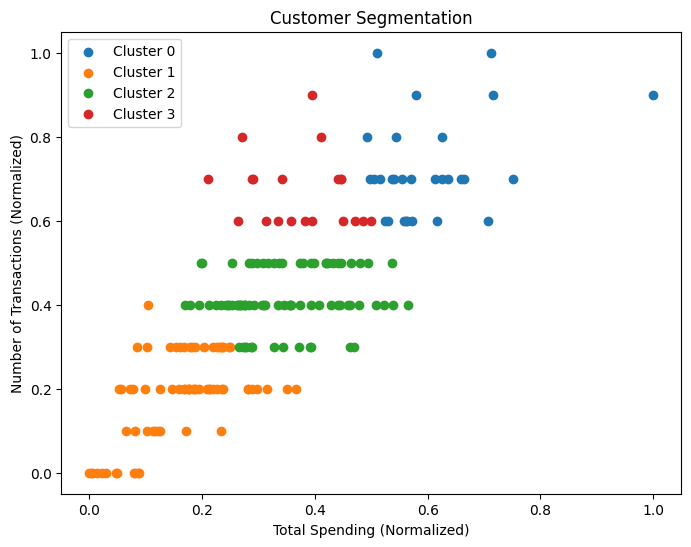

In [23]:
plt.figure(figsize=(8, 6))
for cluster in range(4):
    plt.scatter(
        clustering_data[kmeans.labels_ == cluster, 0],
        clustering_data[kmeans.labels_ == cluster, 1],
        label=f'Cluster {cluster}'
    )
plt.title('Customer Segmentation')
plt.xlabel('Total Spending (Normalized)')
plt.ylabel('Number of Transactions (Normalized)')
plt.legend()
plt.savefig('C:\\Users\\LENOVO\\Downloads\\customer_segmentation_clusters.png')
